**Sentiment Analysis**

This Jupyter Notebook contains code for sentiment analysis of hotel reviews using Python. It includes data loading, data cleaning, sentiment analysis, model training, and model testing. The analysis aims to classify hotel reviews into "Happy" or "Not Happy" categories based on their content.


**Note:** Before running the code, make sure you have the required libraries and data files in your environment.


**IMPORT THE REQUIRED LIBRARIES**

In [13]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')


**DATA LOADING AND TEXT CLEANING**

In [14]:
# Load data
Reviewdata = pd.read_csv('train.csv')

# Remove unnecessary columns
Reviewdata.drop(columns=['User_ID', 'Browser_Used', 'Device_Used'], inplace=True)

# Define text cleaning functions
def text_clean_1(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def text_clean_2(text):
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

# Apply text cleaning
Reviewdata['cleaned_description'] = Reviewdata['Description'].apply(text_clean_1)
Reviewdata['cleaned_description'] = Reviewdata['cleaned_description'].apply(text_clean_2)


In [15]:
# Display the first few rows of the cleaned DataFrame
print("First few rows of the cleaned data:")
print(Reviewdata.head())


First few rows of the cleaned data:
                                         Description Is_Response  \
0  The room was kind of clean but had a VERY stro...   not happy   
1  I stayed at the Crown Plaza April -- - April -...   not happy   
2  I booked this hotel through Hotwire at the low...   not happy   
3  Stayed here with husband and sons on the way t...       happy   
4  My girlfriends and I stayed here to celebrate ...   not happy   

                                 cleaned_description  
0  the room was kind of clean but had a very stro...  
1  i stayed at the crown plaza april   april   th...  
2  i booked this hotel through hotwire at the low...  
3  stayed here with husband and sons on the way t...  
4  my girlfriends and i stayed here to celebrate ...  


In [16]:
# Check the information and summary statistics of the cleaned DataFrame
print("\nData Information:")
print(Reviewdata.info())

print("\nSummary Statistics:")
print(Reviewdata.describe())



Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38932 entries, 0 to 38931
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Description          38932 non-null  object
 1   Is_Response          38932 non-null  object
 2   cleaned_description  38932 non-null  object
dtypes: object(3)
memory usage: 912.6+ KB
None

Summary Statistics:
                                              Description Is_Response  \
count                                               38932       38932   
unique                                              38932           2   
top     The room was kind of clean but had a VERY stro...       happy   
freq                                                    1       26521   

                                      cleaned_description  
count                                               38932  
unique                                              38932  
top     the ro

**DATA VISUALISATION**

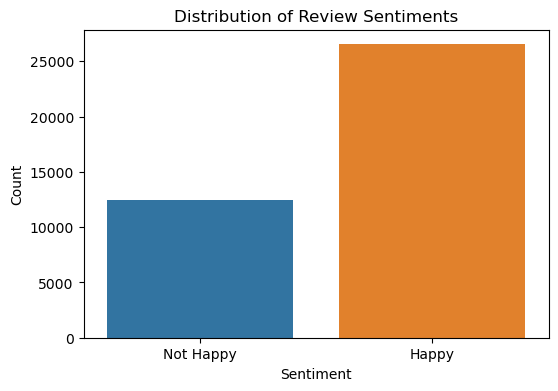

In [17]:
# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=Reviewdata, x='Is_Response')
plt.title('Distribution of Review Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not Happy', 'Happy'])
plt.show()


In [38]:
# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to get sentiment score
def get_sentiment_score(text):
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']

# Apply sentiment analysis and store the results in a new column
Reviewdata['Sentiment_Score'] = Reviewdata['cleaned_description'].apply(get_sentiment_score)



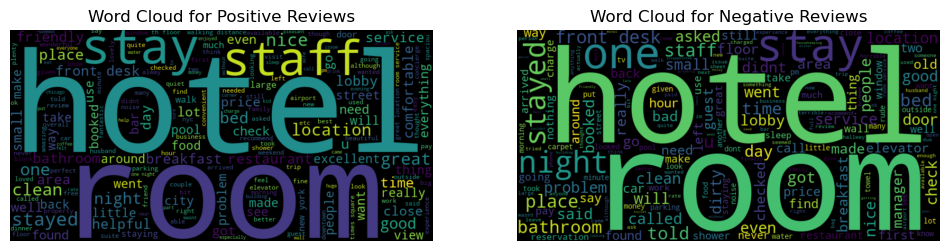

In [19]:
# Create word clouds for positive and negative reviews
positive_reviews = ' '.join(Reviewdata[Reviewdata['Sentiment_Score'] > 0]['cleaned_description'])
negative_reviews = ' '.join(Reviewdata[Reviewdata['Sentiment_Score'] < 0]['cleaned_description'])

wordcloud_positive = WordCloud(width=800, height=400).generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400).generate(negative_reviews)

# Plot the word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')

plt.show()


**MODEL TRAINING AND BUILDING**

In [20]:
from sklearn.pipeline import Pipeline


In [21]:
# Prepare the data for modeling
X = Reviewdata['cleaned_description']
y = Reviewdata['Is_Response']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer and a logistic regression classifier
tfidf_vectorizer = TfidfVectorizer()
clf = LogisticRegression(solver='lbfgs')

# Create a pipeline
model = Pipeline([('vectorizer', tfidf_vectorizer), ('classifier', clf)])

# Fit the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model evaluation
confusion = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print evaluation metrics
print("Confusion Matrix:\n", confusion)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Classification Report
classification_rep = classification_report(y_test, y_pred, target_names=['Not Happy', 'Happy'])
print("\nClassification Report:\n", classification_rep)


Confusion Matrix:
 [[4976  309]
 [ 584 1918]]
Accuracy: 0.8853216899961475
Precision: 0.8841310105328657
Recall: 0.8853216899961475

Classification Report:
               precision    recall  f1-score   support

   Not Happy       0.89      0.94      0.92      5285
       Happy       0.86      0.77      0.81      2502

    accuracy                           0.89      7787
   macro avg       0.88      0.85      0.86      7787
weighted avg       0.88      0.89      0.88      7787



**5-FOLD CROSS-VALIDATION**


In [22]:
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))


Cross-Validation Scores: [0.8806986  0.88390908 0.88877472 0.88530696 0.88158233]
Mean Accuracy: 0.8840543383591198


**MODEL TESTING**

In [37]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
 
# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()


In [26]:
def get_vader_sentiment_score(text):
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']


In [27]:
Reviewdata['VADER_Sentiment_Score'] = Reviewdata['cleaned_description'].apply(get_vader_sentiment_score)


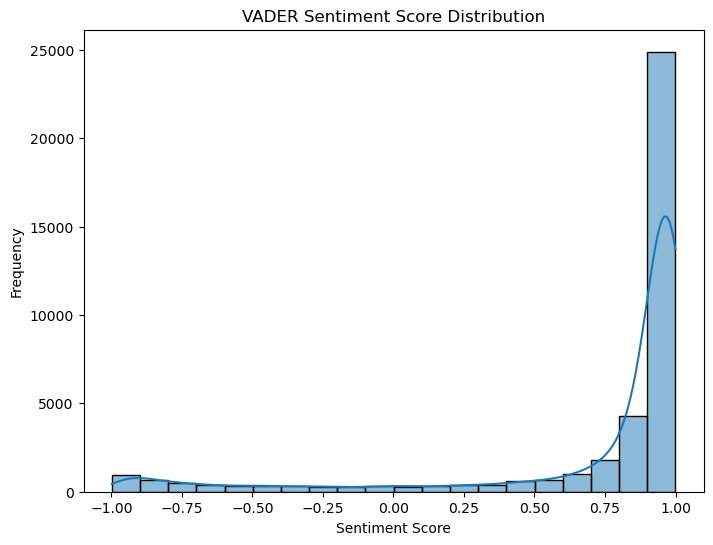

In [28]:
# Visualize the sentiment score distribution
plt.figure(figsize=(8, 6))
sns.histplot(data=Reviewdata, x='VADER_Sentiment_Score', bins=20, kde=True)
plt.title('VADER Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


In [33]:
# Interpret the sentiment score
if result1 >= 0.05:
    sentiment_label = "happy"
elif result1 <= -0.05:
    sentiment_label = "not happy"
else:
    sentiment_label = "neutral"



In [36]:
review = "The hotel staff was very friendly and helpful during our stay. The room was clean and comfortable, and the location was convenient for our needs. Overall, we had a great experience and would recommend this hotel to others."
result1 = get_vader_sentiment_score(review)
print("Sentiment Prediction:", result1)
print("Sentiment Label:", sentiment_label)

Sentiment Prediction: 0.9593
Sentiment Label: unhappy
